In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import cm
from statsmodels.graphics.tsaplots import plot_acf

### Part 1 - Returns Function

In [2]:
def yf_daily_log_returns(ticker_symbol: str, start_date: str, end_date: str) -> pd.Series:
    """Pulls Yahoo! Finance and calculates daily log returns from given start_date, and end_date

    Args:
        ticker_symbol (str): stock ticker
        start_date (str): start date "YYYY-MM-DD"
        end_date (str): end date "YYYY-MM-DD"

    Returns:
        pd.Series: series of log returns
    """
    # your implementation here

    data = yf.download(ticker_symbol, start=start_date, end=end_date, progress=False)

    # Calculate daily log returns
    log_returns = np.log(data['Adj Close']/data['Adj Close'].shift(1))
    
    # Drop NaN values and return the log returns
    return log_returns.dropna()


In [3]:
returns_pd = yf_daily_log_returns(ticker_symbol = "AAPL", start_date = "2010-01-01", end_date = "2024-10-01")

### Part 2 - Log Likelihood Function

In [4]:
def gaussian_ll(returns: pd.Series, vars: pd.Series) -> float:
    """Conditional gaussian log likelihood function

    Args:
        returns (pd.Series): return series
        vs(pd.Series): corresponding variances

    Returns:
        float: ll result
    """
    # your implementation here

    if len(returns) != len(vars):
        raise ValueError("The lengths of returns and variances must match.")

    # Ensure variances are positive to avoid math domain errors
    if (vars <= 0).any():
        raise ValueError("All variances must be positive.")

    log_likelihood = -0.5 * np.sum(np.log(2 * np.pi * vars) + (returns ** 2) / vars)

    return log_likelihood

### Part 3 - EWMA Variance Estimates

In [5]:
def ewma_var_estimates(lmb: float, returns: pd.Series) -> pd.Series:
    """Given an input vector of returns, produces 

    Args:
        lmb (float): lambda parameter
        returns (pd.Series): historical return series sorted
            ascending by date (older dates first)

    Returns:
        pd.Series: the EWMA variance estimates
    """
    assert returns.index.is_monotonic_increasing, "returns are not ascending!"

    # your implementation

    returns_array = returns.to_numpy()
    
    # Initialize an array to store variance estimates
    ewma_variances = np.zeros(len(returns_array))
    
    # Calculate the unconditional variance as the starting value
    initial_variance = np.var(returns_array, ddof=1)
    ewma_variances[0] = initial_variance

    # Loop to calculate the variance estimates
    for t in range(1, len(returns_array)):
        ewma_variances[t] = lmb * ewma_variances[t - 1] + (1 - lmb) * (returns_array[t - 1] ** 2)

    # Convert the numpy array back to a pandas Series
    ewma_var_series = pd.Series(ewma_variances, index=returns.index)

    return ewma_var_series

### Part 4 - EWMA Calibration Objective Function

In [6]:
def ewma_objective(lmb: float, returns: pd.Series):
    """EWMA objective function to minimize

    Args:
        lmb (float): lambda parameter
        returns (pd.Series): the input return series

    Returns:
        float: objective function result
    """
    # your implementation

    ewma_variances = ewma_var_estimates(lmb, returns)

    # Ensure all variances are positive
    if (ewma_variances <= 0).any():
        return np.inf

    # Calculate negative log-likelihood using the gaussian_ll function
    neg_log_likelihood = -gaussian_ll(returns, ewma_variances)

    return neg_log_likelihood

### Part 5 - Calibrate EWMA

In [7]:
def ewma_fit(returns: pd.Series, guess: float = 0.9) -> float:
    """Fits an EWMA volatility model to a historical return
    series using gaussian conditional log-likelihood

    Args:
        returns (pd.Series): historical returns
        guess (float, optional): initial guess for lambda parameter. Defaults to 0.9.

    Returns:
        float: the fitted lambda parameter
    """
    # your implementation here

    bounds = [(1e-6, 0.999)]

    # Run optimization using Nelder-Mead method
    result = minimize(
        ewma_objective,  # Objective function
        x0=[guess],      # Initial guess for lambda
        args=(returns,), # Pass returns as additional argument
        method="Nelder-Mead",
        tol=1e-15,       # Tolerance for convergence
        bounds=bounds    # Bounds for lambda
    )

    # Extract and return the optimal lambda
    if result.success:
        return result.x[0]
    else:
        raise ValueError(f"Optimization failed: {result.message}")

In [8]:
returns_fit = ewma_fit(returns_pd, 0.9)

returns_fit

0.9699570858478546

### Part 6 - Plot the EWMA Objective Function

In [9]:
def plot_ewma_objective(returns: pd.Series, optimal_lambda: float):
    """Plots the EWMA objective function and marks the optimal lambda.

    Args:
        returns (pd.Series): historical returns
        optimal_lambda (float): the lambda value that minimizes the objective function
    """
    # Generate a range of lambda values for plotting
    lambda_values = np.linspace(0.001, 0.999, 1000)
    
    # Calculate the objective function for each lambda
    objective_values = [ewma_objective(lmb, returns) for lmb in lambda_values]
    
    # Find the minimum objective value and its corresponding lambda
    min_objective = ewma_objective(optimal_lambda, returns)

    # Plot the objective function
    plt.figure(figsize=(10, 6))
    plt.plot(lambda_values, objective_values, label="EWMA Objective Function", color="blue")
    plt.axvline(optimal_lambda, color="red", linestyle="--", label=f"Optimal λ = {optimal_lambda:.4f}")
    plt.scatter(optimal_lambda, min_objective, color="red", zorder=5, label="Minimum Objective Value")
    
    # Add labels and legend
    plt.title("EWMA Objective Function", fontsize=16)
    plt.xlabel("Lambda (λ)", fontsize=14)
    plt.ylabel("Objective Function Value", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()


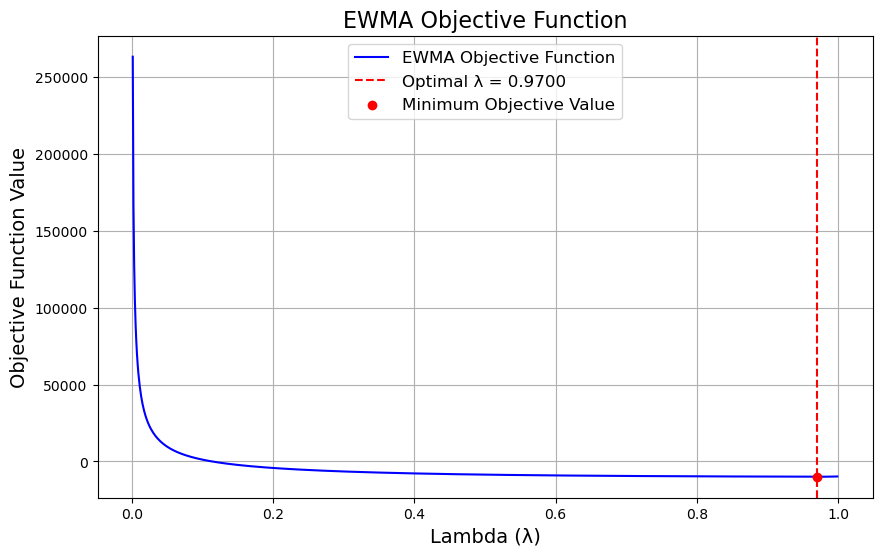

In [10]:
optimal_lambda = ewma_fit(returns_pd, guess=0.9)

# Plot the EWMA objective function
plot_ewma_objective(returns_pd, optimal_lambda)

### Part 7 - GARCH(1,1) Variance Estimates

In [11]:
def garch11_var_estimates(a0: float, a1: float, b1: float, returns: pd.Series) -> pd.Series:
    """GARCH(1,1) Variance estimates

    Args:
        a0 (float): alpha0 param
        a1 (float): alpha1 param
        b1 (float): beta1 param
        returns (pd.Series): historical return series sorted
            ascending by date (older dates first)

    Returns:
        pd.Series: the GARCH(1,1) variance estimates
    """
    assert returns.index.is_monotonic_increasing, "returns are not ascending!"

    # your implementation

    # Initial unconditional variance as a starting point
    unconditional_var = returns.var() 
    variances = np.zeros(len(returns))  # Initialize variance array
    variances[0] = unconditional_var    # Start with unconditional variance

    # Calculate GARCH(1,1) variance estimates
    for t in range(1, len(returns)):
        variances[t] = a0 + a1 * returns.iloc[t - 1]**2 + b1 * variances[t - 1]

    # Convert to Pandas Series with the same index as the input
    return pd.Series(variances, index=returns.index)

### Part 8 - GARCH Calibration Objective Function

In [12]:
def garch11_objective(params: tuple[float, float, float], returns: pd.Series) -> float:
    """GARCH(1,1() objective function to minimize

    Args:
        params (tuple): (a0, a1, b1)
        returns (pd.Series): historical returns

    Returns:
        float: result of objective function
    """
    # unpack params
    a0, a1, b1 = params 

    # your implementation

    # Penalize invalid parameter sets
    if a0 <= 0 or a1 < 0 or b1 < 0 or (a1 + b1 >= 1):
        return np.inf

    # Calculate variance estimates using GARCH(1,1)
    vars_series = garch11_var_estimates(a0, a1, b1, returns)

    # Ensure variances are positive
    if (vars_series <= 0).any():
        return np.inf

    # Compute negative Gaussian log-likelihood
    nll = -gaussian_ll(returns, vars_series)

    return nll

### Part 9 - Calibrate GARCH(1, 1)

In [13]:
def garch11_fit(returns: pd.Series, guess: tuple[float, float, float] = (0.0001, 0.1, 0.8)) -> tuple[float, float, float]:
    """Fits a GARCH(1,1) volatility model to a historical return
    series using gaussian conditional log-likelihood

    Args:
        returns (pd.Series): historical returns
        guess (tuple, optional): Parameter guesses. Defaults to (0.0001, 0.1, 0.8).

    Returns:
        tuple: the fitted GARCH(1,1) parameters
    """
    # your implementation here

    bounds = [
        (1e-8, None),  # a0 > 0
        (0, 1),        # 0 <= a1 < 1
        (0, 1),        # 0 <= b1 < 1
    ]

    # Define the constraint: a1 + b1 < 1
    constraints = {
        'type': 'ineq',
        'fun': lambda params: 1 - (params[1] + params[2])  # Ensures a1 + b1 < 1
    }

    # Minimize the GARCH(1,1) objective function
    result = minimize(
        garch11_objective,
        guess,
        args=(returns,),
        method="Nelder-Mead",
        bounds=bounds,
        tol=1e-15
    )

    # Return the optimized parameters
    return tuple(result.x)

In [14]:
returns_garch11 = garch11_fit(returns_pd)

returns_garch11

(1.601449790122414e-05, 0.08978772450615365, 0.8582669538738866)

### Part 10 - Plot Correlograms (Similar to Above) of Squared Standardized Residuals

In [15]:
def plot_squared_standardized_residuals_acf(returns: pd.Series, garch_params: tuple, ewma_lambda: float):
    """
    Plots ACF of squared standardized residuals for both GARCH(1,1) and EWMA models.

    Args:
        returns (pd.Series): historical return series
        garch_params (tuple): (a0, a1, b1) parameters of the fitted GARCH(1,1) model
        ewma_lambda (float): lambda parameter of the EWMA model
    """
    # GARCH(1,1) model residuals
    garch_vars = garch11_var_estimates(*garch_params, returns)
    garch_residuals = returns - 0  # Assuming mean 0 for residuals
    garch_standardized_residuals = garch_residuals / np.sqrt(garch_vars)
    garch_squared_standardized_residuals = garch_standardized_residuals ** 2

    # EWMA model residuals
    ewma_vars = ewma_var_estimates(ewma_lambda, returns)
    ewma_residuals = returns - 0  # Assuming mean 0 for residuals
    ewma_standardized_residuals = ewma_residuals / np.sqrt(ewma_vars)
    ewma_squared_standardized_residuals = ewma_standardized_residuals ** 2

    # Plot ACF for GARCH(1,1)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plot_acf(garch_squared_standardized_residuals, lags=20, ax=plt.gca())
    plt.title("ACF of Squared Standardized Residuals (GARCH(1,1))")

    # Plot ACF for EWMA
    plt.subplot(1, 2, 2)
    plot_acf(ewma_squared_standardized_residuals, lags=20, ax=plt.gca())
    plt.title("ACF of Squared Standardized Residuals (EWMA)")

    plt.tight_layout()
    plt.show()

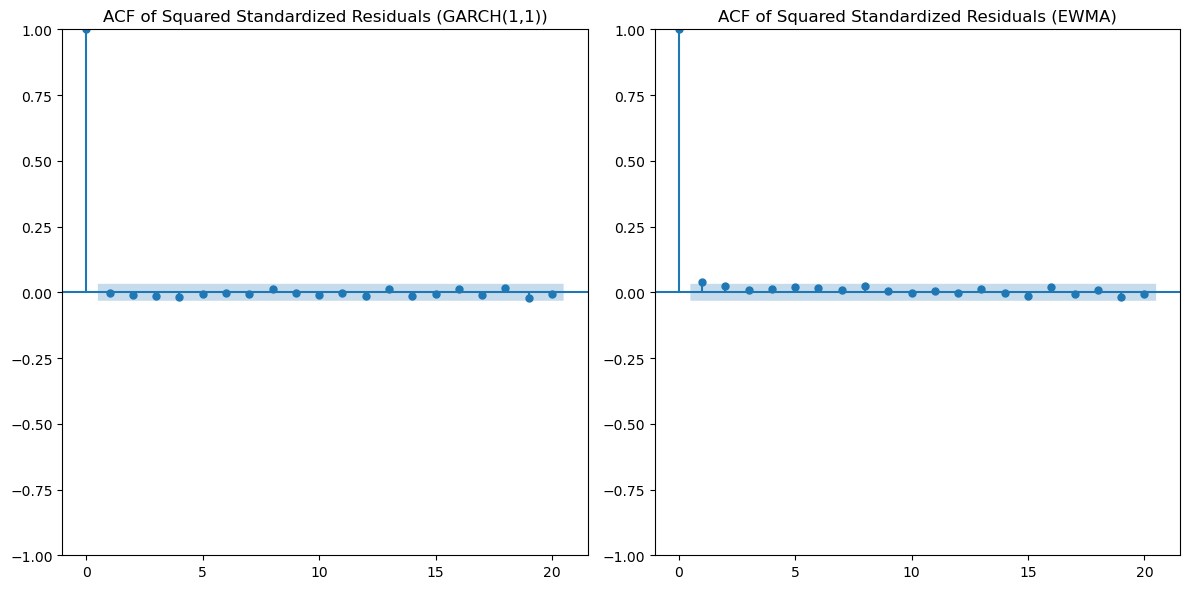

In [16]:
returns_garch_plot = plot_squared_standardized_residuals_acf(returns_pd, returns_garch11, optimal_lambda)

### Part 11 - Surface Plot

In [17]:
def surface_plot_garch11(returns: pd.Series, constant_a0: float = 0.0001):
    """Creates a 3D surface plot of the GARCH(1,1) log-likelihood with alpha0 held constant.

    Args:
        returns (pd.Series): historical return series.
        constant_a0 (float): the constant value for alpha0.
    """
    # Define the parameter ranges for alpha1 and beta1
    alpha1_range = np.linspace(0.01, 0.99, 50)  # Values for alpha1
    beta1_range = np.linspace(0.01, 0.99, 50)   # Values for beta1

    # Create meshgrid for the parameter space
    alpha1_vals, beta1_vals = np.meshgrid(alpha1_range, beta1_range)
    
    # Initialize an empty matrix to store the log-likelihood values
    ll_vals = np.zeros_like(alpha1_vals)

    # Loop through each combination of alpha1 and beta1
    for i in range(alpha1_vals.shape[0]):
        for j in range(alpha1_vals.shape[1]):
            params = (constant_a0, alpha1_vals[i, j], beta1_vals[i, j])
            ll_vals[i, j] = garch11_objective(params, returns)  # Evaluate the objective function

    # Plot the surface
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(alpha1_vals, beta1_vals, ll_vals, cmap='viridis')

    # Labels and title
    ax.set_xlabel('alpha1')
    ax.set_ylabel('beta1')
    ax.set_zlabel('Negative Log-Likelihood')
    ax.set_title('Surface Plot of GARCH(1,1) Log-Likelihood')

    # Show the plot
    plt.show()

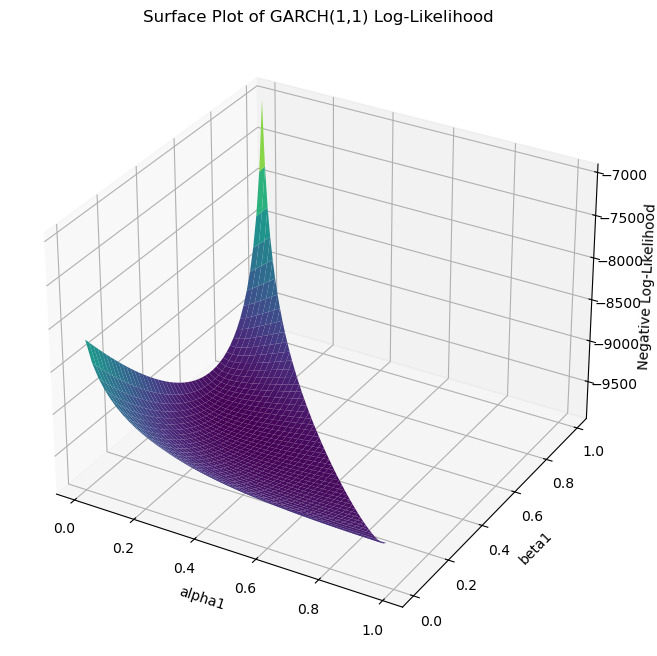

In [18]:
surface_plot_garch11(returns_pd)